# Modélisation par regréssion Logistique

Etape 1 : Importation des bibliothèques

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, roc_curve, precision_recall_curve, confusion_matrix

Etape 2 : Importation et traitement des données

In [2]:
df = pd.read_csv('new.csv')

In [3]:
df.columns

Index(['matricule', 'first_name', 'last_name', 'date_naiss', 'gender',
       'ministry', 'grade', 'diff_recens', 'diff_conges', 'diff_travail',
       'actif', 'salaire', 'fraude'],
      dtype='object')

Notre attribut cible est le champs 'Fraude'

In [4]:
df.head()

,matricule,first_name,last_name,date_naiss,gender,ministry,grade,diff_recens,diff_conges,diff_travail,actif,salaire,fraude
0,596611-N,Geneva,Zeale,1/14/1983,Polygender,MINSUP,D,11704170,926852,936804214,0,55882,fraude
1,100483-M,Bernadina,Aveling,3/30/1986,Female,MINREX,B,5629471,4017514,27910509,0,183392,fraude
2,365372-Y,Edithe,Morcombe,5/27/1973,Female,MINSEC,A,27025341,18350,1756832317,1,289321,fraude
3,321101-U,Sherri,Varney,6/27/1970,Female,MINCOM,A,22684335,1126557,1341097577,1,298163,fraude
4,543502-Q,Kane,Mitchenson,9/28/1986,Male,MINEDUB,B,23523844,422528,857325794,1,163498,fraude


In [5]:
# Comptons les différentes valeurs presentes dans le champs 'Fraude'
df['fraude'].value_counts() 

fraude
fraude        3153
pas fraude    2847
Name: count, dtype: int64

<Axes: xlabel='fraude', ylabel='count'>

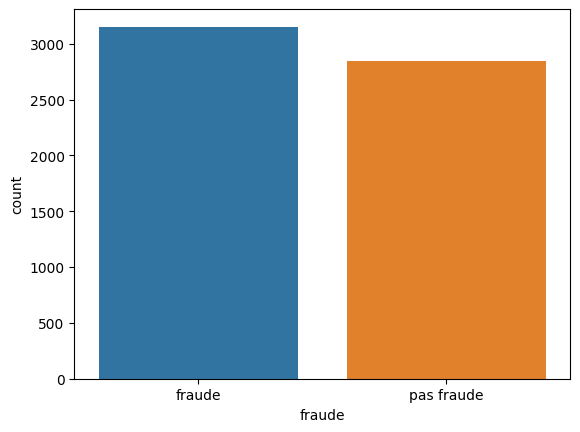

In [6]:
#visualisation du rapport entre nos deux classes de la cible
sns.countplot(x='fraude', data=df) 

<Axes: xlabel='fraude', ylabel='salaire'>

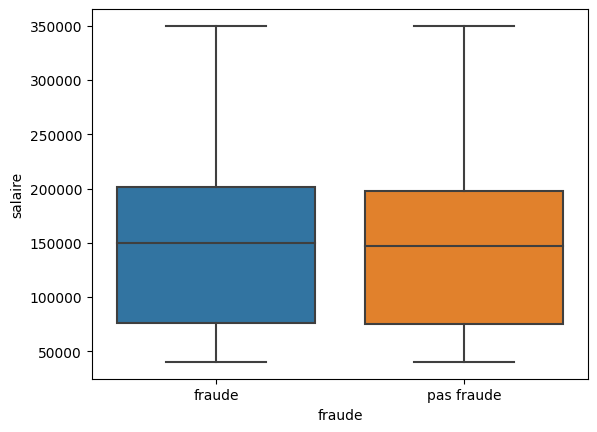

In [8]:
# Boîte à moustache pour la dispersion des données
sns.boxplot(x='fraude', y="salaire", data=df)

In [9]:
# Informations sur les attributs
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   matricule     6000 non-null   object
 1   first_name    6000 non-null   object
 2   last_name     6000 non-null   object
 3   date_naiss    6000 non-null   object
 4   gender        6000 non-null   object
 5   ministry      6000 non-null   object
 6   grade         6000 non-null   object
 7   diff_recens   6000 non-null   int64 
 8   diff_conges   6000 non-null   int64 
 9   diff_travail  6000 non-null   int64 
 10  actif         6000 non-null   int64 
 11  salaire       6000 non-null   int64 
 12  fraude        6000 non-null   object
dtypes: int64(5), object(8)
memory usage: 609.5+ KB


<Axes: >

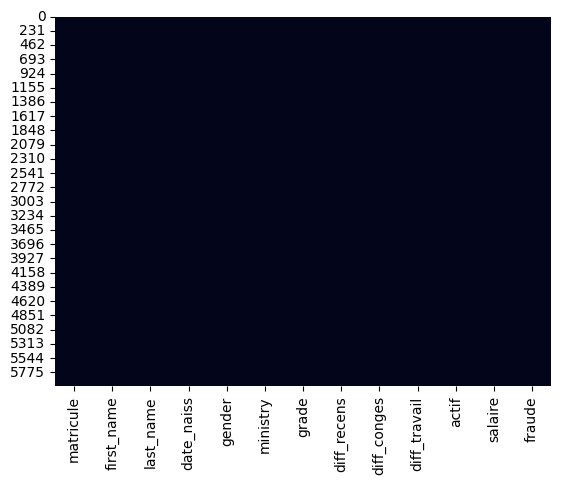

In [10]:
# Vérification des valeurs manquantes
sns.heatmap(df.isnull(), cbar=False)

Etape 3 : Transformation des variables catégorielles en variables fictives

Ici, chaque valeurs de champs important va avoir une colonne et si à un client correspond une valeur, alors il aura True(1) et False(0) sinon.  

Comptons et affichons les occurences de chaques champs importats pour la prédiction (grade, gender, actif)

In [14]:
df['gender'].value_counts(dropna=False) 

gender
Male           2730
Female         2686
Bigender        114
Genderfluid     113
Genderqueer      99
Non-binary       90
Agender          87
Polygender       81
Name: count, dtype: int64

In [15]:
df['grade'].value_counts(dropna=False) 

grade
C    1545
D    1495
B    1493
A    1467
Name: count, dtype: int64

In [16]:
df['actif'].value_counts(dropna=False) 

actif
1    4011
0    1989
Name: count, dtype: int64

Créons des variables fictives pour des attributs pertinents

In [17]:
# Création des minis dataframes des variables fictives
Gender_data = pd.get_dummies(df['gender'], drop_first=True)
Grade_data = pd.get_dummies(df['grade'], drop_first=True)
Actif_data = pd.get_dummies(df['actif'], drop_first=True)

In [18]:
# Créons une copie de notre dataset pour la suite
clean = df.copy()

In [19]:
#Supression des colonnes catégorielles que nous n'utiliserons pas
clean.drop(['matricule', 'first_name', 'last_name', 'date_naiss', 'gender',
       'ministry', 'grade', 'actif'], axis=1, inplace = True)

In [20]:
# Affichage du dataframe
clean

,diff_recens,diff_conges,diff_travail,salaire,fraude
0,11704170,926852,936804214,55882,fraude
1,5629471,4017514,27910509,183392,fraude
2,27025341,18350,1756832317,289321,fraude
3,22684335,1126557,1341097577,298163,fraude
4,23523844,422528,857325794,163498,fraude
...,...,...,...,...,...
5995,11387940,2900045,1240911779,60576,fraude
5996,18158809,2119075,1151342050,136882,fraude
5997,17001798,2879610,1239354026,136294,fraude
5998,26378705,5730339,1768460321,178412,fraude


In [21]:
# Ajoutons à notre dataframe les dataframes créés à partie des
# colonnes gender, actif et grade
clean = pd.concat([clean, Gender_data, Grade_data, Actif_data], axis=1)

In [22]:
# Affichons le nouveau dataframe
clean

,diff_recens,diff_conges,diff_travail,salaire,fraude,Bigender,Female,Genderfluid,Genderqueer,Male,Non-binary,Polygender,B,C,D,1
0,11704170,926852,936804214,55882,fraude,False,False,False,False,False,False,True,False,False,True,False
1,5629471,4017514,27910509,183392,fraude,False,True,False,False,False,False,False,True,False,False,False
2,27025341,18350,1756832317,289321,fraude,False,True,False,False,False,False,False,False,False,False,True
3,22684335,1126557,1341097577,298163,fraude,False,True,False,False,False,False,False,False,False,False,True
4,23523844,422528,857325794,163498,fraude,False,False,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,11387940,2900045,1240911779,60576,fraude,False,True,False,False,False,False,False,False,False,True,True
5996,18158809,2119075,1151342050,136882,fraude,False,True,False,False,False,False,False,False,True,False,False
5997,17001798,2879610,1239354026,136294,fraude,False,True,False,False,False,False,False,False,True,False,False
5998,26378705,5730339,1768460321,178412,fraude,False,True,False,False,False,False,False,True,False,False,True


In [25]:
df = df.rename(columns={1:'1'})

In [27]:
# Séparation des champs numériques des champs catégoriels
numeric_cols = ['diff_recens', 'diff_conges', 'diff_travail', 'salaire']
cat_cols = list(set(clean.columns) - set(numeric_cols) - {'fraude'}) #Une liste formée des attributs non numériques et sans l'attribut cible
#cat_cols.sort() # Trie de la liste

print(numeric_cols)
print(cat_cols)

['diff_recens', 'diff_conges', 'diff_travail', 'salaire']
['Polygender', 1, 'Genderfluid', 'Female', 'Non-binary', 'D', 'Genderqueer', 'B', 'Male', 'C', 'Bigender']


Etape 4: Séparation des ensembles des données

In [28]:
random_seed = 888

# Utilisons 20% des données comme données de tests
df_train, df_test = train_test_split(clean, test_size=0.2, random_state=random_seed, stratify=clean['fraude'])


print(df_train.shape)
print(df_test.shape)
print()
print(df_train['fraude'].value_counts(normalize=True))
print()
print(df_test['fraude'].value_counts(normalize=True))

(4800, 16)
(1200, 16)

fraude
fraude        0.525417
pas fraude    0.474583
Name: proportion, dtype: float64

fraude
fraude        0.525833
pas fraude    0.474167
Name: proportion, dtype: float64


Etape 5: Transformation des variables numériques : mise à l'échelle

In [30]:
scaler = StandardScaler()
#Faisons la mise à l'échelle des variables numériques
# Ajustons les grace à l'écart-type
scaler.fit(df_train[numeric_cols]) 

def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols]) # Tableau de normalisation des attributs numériques
    #print(X_numeric_scaled)
    X_categorical = df[cat_cols].to_numpy() # Transformation des attributs catégoriels en tableau numpy
    #print(X_categorical)
    X = np.hstack((X_categorical, X_numeric_scaled)) # Fusion des deux tableaux
    y = df['fraude'] # Affectation de la colonne cible
    return X, y

# y_target = colonne cible
X, y_target = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)

Etape 6 : Ajustement du modèle de régression logistique

In [31]:
Model = LogisticRegression() # logistic regression with no penalty term in the cost function.

Model.fit(X, y_target)

LogisticRegression()

Etape 7: Evaluation du modèle

In [32]:
# Jeu de données mis à l'échelle
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)
y_test

5686        fraude
648         fraude
5595        fraude
3056    pas fraude
3078    pas fraude
           ...    
3720    pas fraude
5672        fraude
3827    pas fraude
3212    pas fraude
1745        fraude
Name: fraude, Length: 1200, dtype: object

In [33]:
probs = Model.predict_proba(X_test)
prob = probs[:,1]

In [34]:
# Fonction pour tracer la courbe ROC
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC(Receiver Operating Characteristic Curve)')
    plt.legend()
    plt.show()

In [37]:
# Calcul des paramètres pour la courbe en fonction d'une des valeurs de la cible
fper, tper, residus = roc_curve(y_test, prob, pos_label='fraude')

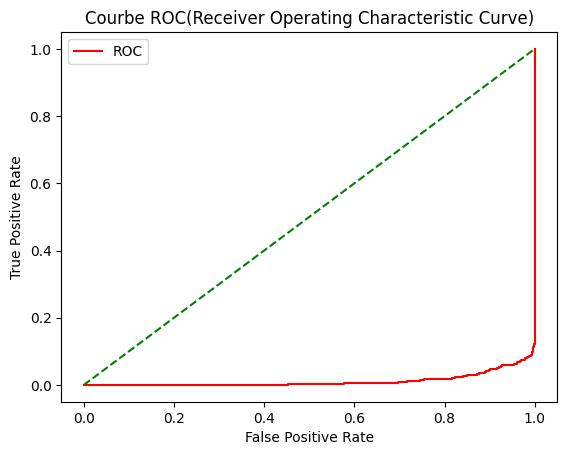

In [38]:
# Tracé de la courbe
plot_roc_curve(fper, tper)

In [39]:
# Fonction pour tracer la corbe des prévisions
def plot_precision_recall_curve(rec, pre):
    plt.plot(fper, tper, color='red', label='Precision')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Courbe Precision Recall Curve)')
    plt.legend()
    plt.show()

In [40]:
 # Prédiction du model selon les données test
prev = Model.predict(X_test)

In [ ]:
#rec, pre, residus0 = precision_recall_curve(y_test, prev, pos_label=' >50K')

In [43]:
# Calcul des predictions test
test_prob = Model.predict_proba(X_test)[:, 1]
test_pred = Model.predict(X_test)

In [46]:
# Affichage des différents scores
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob, pos_label='fraude')))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred, pos_label='fraude')))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred, pos_label='fraude')))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred, pos_label='fraude')))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.13255
AUC = 0.98831
Average Precision = 0.32788

Using 0.5 as threshold:
Accuracy = 0.94750
Precision = 0.96405
Recall = 0.93502
F1 score = 0.94932

Classification Report
              precision    recall  f1-score   support

      fraude       0.96      0.94      0.95       631
  pas fraude       0.93      0.96      0.95       569

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



In [47]:
# Confusion Matrix
y_pred = Model.predict(X_test)
mat_con = confusion_matrix(y_true=y_test, y_pred=y_pred)

Text(50.722222222222214, 0.5, 'Valeurs actuelles')

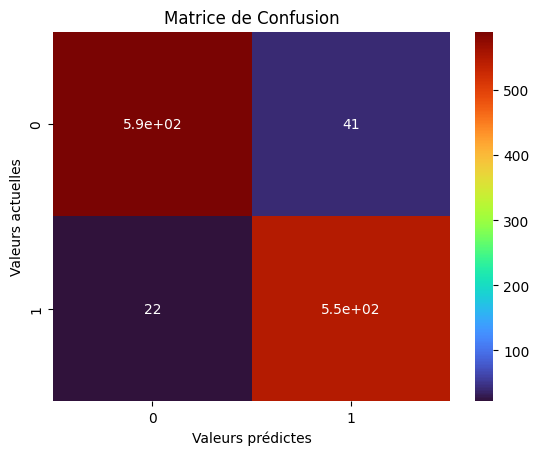

In [48]:
#Création d'un carré
fx = sns.heatmap(mat_con, annot=True, cmap='turbo')

fx.set_title('Matrice de Confusion')
fx.set_xlabel('Valeurs prédictes')
fx.set_ylabel('Valeurs actuelles')

Etape 8: Interprétation des résultats

In [50]:
coefficients = np.hstack((Model.intercept_, Model.coef_[0]))
pd.DataFrame(data={'variable': ['intercept'] + cat_cols + numeric_cols, 'coefficient': coefficients})

,variable,coefficient
0,intercept,-8.975793
1,Polygender,0.025655
2,1,9.525355
3,Genderfluid,0.537373
4,Female,0.126762
5,Non-binary,-0.218723
6,D,0.393480
7,Genderqueer,0.384053
8,B,0.138704
9,Male,0.272886


In [51]:
# Calcul de l'écart-type de chaque variable numériques
pd.DataFrame(data={'variable': numeric_cols, 'unit': np.sqrt(scaler.var_)}) 

,variable,unit
0,diff_recens,7.775118e+06
1,diff_conges,1.608008e+06
2,diff_travail,5.671431e+08
3,salaire,8.434339e+04


Interprétations: